# Read Importing Some Important Packages

In [129]:
import numpy as np
import pandas as pd
import dlib
import cv2
import sys
#!{sys.executable} -m pip install openface
#import openface
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import argparse
import imutils
import imgaug as ia
from imgaug import augmenters as iaa
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import math
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

Using Image.Open to read grey scale image

In [333]:
basewidth = 200
img=Image.open('/Users/changyuean/Python/My Own Programming Scripts/Facial Recognition System for Adam/Photos/24.jpg').convert("LA")
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)

Display image

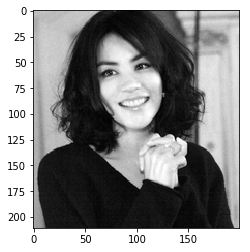

In [334]:
plt.imshow(img)

Using dlib to automatically detect the face and crop the image

# Define a function to import all pictures data and do one-hot encoding on target variables

In [335]:
def im_pic(import_path = "../Facial Recognition System for Adam/Photos/"):
    #read the excel file which contains image information
    im_list  = pd.read_excel(import_path+"Photo.xlsx")
    #one-hot encode the targetted label
    encoder = preprocessing.LabelEncoder()
    encoder.fit(im_list["Name"])
    processing_label = encoder.transform(im_list["Name"])
    processing_label = processing_label.reshape(-1,1)
    ohe = preprocessing.OneHotEncoder(sparse=False)
    target_label = ohe.fit_transform(processing_label)
    #create a list of image to store all of the images
    images = []
    basewidth = 200
    for ID in im_list["Picture ID"]:
        image = io.imread(import_path+str(ID)+".jpg")
        images.append(image)
    return images, target_label, im_list

In [336]:
images, target_label, im_list = im_pic(import_path = "../Facial Recognition System for Adam/Photos/")

In [337]:
target_label.shape

(60, 10)

# Define a function to detect face edges

In [338]:
def detect_faces():
    #Takes a list of images, and for each image returns the boundaries around the detected face.
    images,target_label,_ = im_pic()
    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()
    #create lists of detected_face and face_frame
    detected_faces = []
    face_frames = []
    for image in images:
        # Run detector and get bounding boxes of the faces on image.
        detected_face = face_detector(image, 1)
        detected_faces.append(detected_face) #append detected face to list
        face_frame = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_face]
        face_frames.append(face_frame) #append face frame to list
        
    return face_frames

# Define a function to select face from image

In [339]:
#function to import image
def face_detect():
    #using the face detect function
    images,target_label,_ = im_pic()
    detected_faces = detect_faces()
    faces = [] #create a list to store all identified faces
    #using a loop to get the face
    for i in range(len(detected_faces)):
        if detected_faces[i]:
            for n, face_rect in enumerate(detected_faces[i]):
                face = Image.fromarray(images[i]).crop(face_rect) 
                face = face.convert("L")
            faces.append(face)
        else:
            print("No face detected")
    return faces

In [340]:
#define a function to reshape all of the pictures based on the smallest size of the pictures
def img_res():
    
    faces = face_detect() #get all of the faces from the face detect function
    basewidth = 52 #define the basewidth of all of the pictures
    shrink_faces = [] #create an empty list to store all shrinked faces
    for face in faces:
        wpercent = (basewidth / float(face.size[0]))
        if int(float(face.size[1]) * float(wpercent)) < 52:
            hsize = math.ceil(float(face.size[1]) * float(wpercent))
        else:
            hsize = int(float(face.size[1]) * float(wpercent))
        face = face.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
        shrink_faces.append(face)
    
    return shrink_faces

# Define a function to transfer image data into numpy array and normalize it

In [341]:
#define a function to transform image to numpy array and normalize the image
def im_to_array():
    shrink_faces = img_res()
    face_arrays = [] #create an array to store all face array
    for i in range(len(shrink_faces)):
        face_array = np.asarray(shrink_faces[i])/255 #normalize the data
        face_array = face_array.reshape(face_array.shape[0],face_array.shape[1],1)
        face_arrays.append(face_array)
    return face_arrays

In [213]:
face_arrays = im_to_array()

# Define a function to create training and testing datasets

In [342]:
#define another train test split function to randomly split data instead of bootstrap split
def train_test_partition(t_size):
    
    face_arrays = im_to_array()
    _, target_label, im_list = im_pic()
    
    X_train, X_test, Y_train, Y_test = train_test_split(face_arrays, target_label, test_size=t_size, random_state=1)
    
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, X_test, Y_train, Y_test

In [253]:
"""
def train_test_partition_(t_size):
    reshape_face_arrays = im_to_array()
    _, target_label, im_list = im_pic()
    #get all unique names from the image list
    unique_names = im_list["Name"].unique()
    #creating a dictionary for X variable and a dictionary for Y variable
    X_dic = {}
    Y_dic = {}
    i = 0 #creating a variable i to separate the list of face arrays (0-5 is Taylor Swift, 6-11 is Johnny Depp...)
    
    #store values respect their name
    for name in unique_names:
        X_dic[name] = reshape_face_arrays[i:i+6]
        Y_dic[name] = target_label[i:i+6]
        i+=6
        
    #creating train and test split data sets using bootstrap sampling method
    #create concatename arrays holder to store X_train, X_test, Y_train, and Y_test
    X_train_conc = np.empty([0,155,155,1])
    X_test_conc = np.empty([0,155,155,1])
    Y_train_conc = np.empty([0,len(unique_names)])
    Y_test_conc = np.empty([0,len(unique_names)])
    
    for name in unique_names:
        X_train, X_test, Y_train, Y_test = train_test_split(X_dic[name], Y_dic[name], test_size=t_size, random_state=1)
        X_train_conc = np.concatenate((X_train_conc,X_train), axis = 0)
        X_test_conc = np.concatenate((X_test_conc,X_test), axis = 0)
        Y_train_conc = np.concatenate((Y_train_conc,Y_train), axis = 0)
        Y_test_conc = np.concatenate((Y_test_conc,Y_test), axis = 0)
    #print(Y_train_conc.shape) double check if Y_train_conc get the correct dimension
    #print(Y_test_conc.shape)       
    
    return X_train_conc, X_test_conc, Y_train_conc, Y_test_conc
"""

# Build a Convolutional Neural Network to Classify Images

Creating a function to create placeholder of tensorflow

In [343]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X,Y

In [320]:
X, Y = create_placeholders(155, 155, 1, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 155, 155, 1), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 10), dtype=float32)


Creating a function to initialize parameters

In [344]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    tf.set_random_seed(1)                              

    W1 = tf.get_variable("W1", [4,4,1,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

Define a forward propogation function

In [345]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,2,2,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,2,2,1], padding = 'SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, num_outputs=10, activation_fn=None)

    return Z3

Creating a cost function

In [346]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

Creating a main function for the model

In [347]:
def main(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 155, 155, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 155, 155, 1)
    Y_test -- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = np.shape(X_train)            
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    #print("Y.shape",Y.shape)
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    #print("Z3.shape",Z3.shape)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [348]:
X_train, X_test, Y_train, Y_test =  train_test_partition(t_size = 0.1)

Cost after epoch 0: 7.588546
Cost after epoch 5: 4.559836
Cost after epoch 10: 4.053612
Cost after epoch 15: 2.368983
Cost after epoch 20: 0.736905
Cost after epoch 25: 0.141689
Cost after epoch 30: 0.017385
Cost after epoch 35: 0.006460
Cost after epoch 40: 0.002268
Cost after epoch 45: 0.001108
Cost after epoch 50: 0.000776
Cost after epoch 55: 0.000633
Cost after epoch 60: 0.000556
Cost after epoch 65: 0.000524
Cost after epoch 70: 0.000486
Cost after epoch 75: 0.000430
Cost after epoch 80: 0.000398
Cost after epoch 85: 0.000371
Cost after epoch 90: 0.000360
Cost after epoch 95: 0.000337
Cost after epoch 100: 0.000327
Cost after epoch 105: 0.000289
Cost after epoch 110: 0.000276
Cost after epoch 115: 0.000257
Cost after epoch 120: 0.000240
Cost after epoch 125: 0.000224
Cost after epoch 130: 0.000225
Cost after epoch 135: 0.000209
Cost after epoch 140: 0.000199
Cost after epoch 145: 0.000188
Cost after epoch 150: 0.000169
Cost after epoch 155: 0.000163
Cost after epoch 160: 0.000158

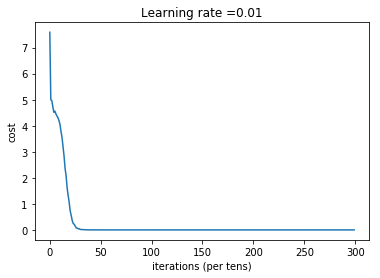

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.5


In [349]:
train_accuracy, test_accuracy, parameters = main(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 300, minibatch_size = 32, print_cost = True)

# --------------------------------------------------------------------------------------------

# Build Residual Net to see if I can improve the accuracy

In [276]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


Build an identity block
<img src="convblock_kiank.png" style="width:650px;height:150px;">

In [277]:
def identity_block(X, f, filters, stage, block): #the function is from Coursera DeepLearning Class
    
    """
    X: input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
    f: integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides=(1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size= (1, 1), strides=(1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Build a convolution block

In [278]:
def convolutional_block(X, f, filters, stage, block, s=2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    #shortcut path
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base +'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# Building a 50-layers residual net

<img src="resnet_kiank.png" style="width:850px;height:150px;">

In [279]:
def ResNet50(input_shape = (155, 155, 3), classes = 10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    print(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [155, 155, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [155, 155, 256], stage=2, block='b')
    X = identity_block(X, 3, [155, 155, 256], stage=2, block='c')


    # Stage 3
    X = convolutional_block(X, f = 3, filters = [310,310,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [310,310,512], stage=3, block='b')
    X = identity_block(X, 3, [310,310,512], stage=3, block='c')
    X = identity_block(X, 3, [310,310,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [620, 620, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [620, 620, 1024], stage=4, block='b')
    X = identity_block(X, 3, [620, 620, 1024], stage=4, block='c')
    X = identity_block(X, 3, [620, 620, 1024], stage=4, block='d')
    X = identity_block(X, 3, [620, 620, 1024], stage=4, block='e')
    X = identity_block(X, 3, [620, 620, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [1240, 1240, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [1240, 1240, 2048], stage=5, block='b')
    X = identity_block(X, 3, [1240, 1240, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2, 2))(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [284]:
model = ResNet50(input_shape = (52, 52, 1), classes = 10)

(52, 52, 1)


In [285]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [286]:
Y_train.shape

(54, 10)

In [297]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 16)

Epoch 1/10
54/54 [==============================] - 19s 348ms/step - loss: 1.0024 - acc: 0.6667
Epoch 2/10
54/54 [==============================] - 18s 328ms/step - loss: 0.9690 - acc: 0.6852
Epoch 3/10
54/54 [==============================] - 18s 332ms/step - loss: 1.8192 - acc: 0.6852
Epoch 4/10
54/54 [==============================] - 18s 334ms/step - loss: 1.0011 - acc: 0.7963
Epoch 5/10
54/54 [==============================] - 18s 333ms/step - loss: 0.8134 - acc: 0.7037
Epoch 6/10
54/54 [==============================] - 20s 363ms/step - loss: 0.3861 - acc: 0.8333
Epoch 7/10
54/54 [==============================] - 52s 956ms/step - loss: 0.5716 - acc: 0.7778
Epoch 8/10
54/54 [==============================] - 21s 381ms/step - loss: 0.6944 - acc: 0.8519
Epoch 9/10
54/54 [==============================] - 20s 365ms/step - loss: 0.4026 - acc: 0.9444
Epoch 10/10
54/54 [==============================] - 18s 335ms/step - loss: 0.7778 - acc: 0.8148


In [298]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

6/6 [==============================] - 0s 61ms/step
Loss = 9.89736557006836
Test Accuracy = 0.0
